# Model Search - Standardization

In this notebook we will continue the model evaluation process, introducing a preprocessing step to standardize the data with mean 0 and standard deviation 1.  This will probably not help the Random Forest models but we should a least see performance improvements (and thus convergence for models without analytic solutions)

In [5]:
# get the data and resample
import ml_utils as mu

# get the training data
data = mu.get_training_data()
X, y = mu.split_x_and_y(data)

# get the holdout and outside validation data
Xh, yh = mu.split_x_and_y(mu.get_holdout_data())
Xh, yh = mu.resample_to_equal_class_sizes(Xh, yh)

Xv, yv = mu.split_x_and_y(mu.get_validation_data())
Xv, yv = mu.resample_to_equal_class_sizes(Xv, yv)

Maximum class size is 80
Class 0 size is 48. Resampling with replacement to 80
Class 1 size has max class size (80).
Class 2 size is 11. Resampling with replacement to 80
Class 3 size is 11. Resampling with replacement to 80
Maximum class size is 32
Class 0 size is 6. Resampling with replacement to 32
Class 1 size has max class size (32).
Class 2 size is 4. Resampling with replacement to 32
Class 3 size is 8. Resampling with replacement to 32


In [2]:
from imblearn.pipeline import Pipeline
import pandas as pd

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold, cross_val_score

classifiers = mu.get_baseline_models()

models = [clf['name'] for clf in classifiers]
df = pd.DataFrame(columns=['acc', 'acc_standardized', 'acc_standard_holdout', 'acc_standard_validation'], index=models)

for clf in classifiers:
    model = clf['model']
    name = clf['name']

    ## Without Standardization
    pipeline = Pipeline([
        ('oversampler', RandomOverSampler()),
        ('classifier', model)
    ])

    print("Running the pipeline without standardization for %s" %name)
    cross_val_acc = cross_val_score(pipeline, X, y, cv=StratifiedKFold(5)).mean()
    df.loc[clf['name']]['acc'] = cross_val_acc
    
    ## With Standardization
    pipeline = Pipeline([
        ('standardization', StandardScaler()),
        ('oversampler', RandomOverSampler()),
        ('classifier', model)
    ])

    print("Running the pipeline WITH standardization for %s" %name)
    cross_val_acc = cross_val_score(pipeline, X, y, cv=StratifiedKFold(5)).mean()
    df.loc[name]['acc_standardized'] = cross_val_acc

    ## Fit with Models with Standardization to the full dataset and evaluate on the holdout and validation data
    pipeline.fit(X,y)
    df.loc[name]['acc_standard_holdout'] = pipeline.score(Xh, yh)
    df.loc[name]['acc_standard_validation'] = pipeline.score(Xv, yv)

df

Running the pipeline without standardization for knn
Running the pipeline WITH standardization for knn
Running the pipeline without standardization for svc_lin
Running the pipeline WITH standardization for svc_lin
Running the pipeline without standardization for svc_rbf
Running the pipeline WITH standardization for svc_rbf
Running the pipeline without standardization for rand_for
Running the pipeline WITH standardization for rand_for
Running the pipeline without standardization for ada
Running the pipeline WITH standardization for ada
Running the pipeline without standardization for gnb
Running the pipeline WITH standardization for gnb
Running the pipeline without standardization for log
Running the pipeline WITH standardization for log
Running the pipeline without standardization for ann
Running the pipeline WITH standardization for ann


,acc,acc_standardized,acc_standard_holdout,acc_standard_validation
knn,0.645998,0.65111,0.6125,0.570312
svc_lin,0.672638,0.812353,0.815625,0.804688
svc_rbf,0.622602,0.53527,0.25,0.25
rand_for,0.818887,0.844057,0.765625,0.734375
ada,0.658577,0.665935,0.58125,0.65625
gnb,0.766725,0.766699,0.759375,0.765625
log,0.773535,0.783605,0.75,0.664062
ann,0.698063,0.845715,0.753125,0.664062


**TODO**: Look into whether or not we should exclude 'Sex' from the standardization step since it is a binary feature

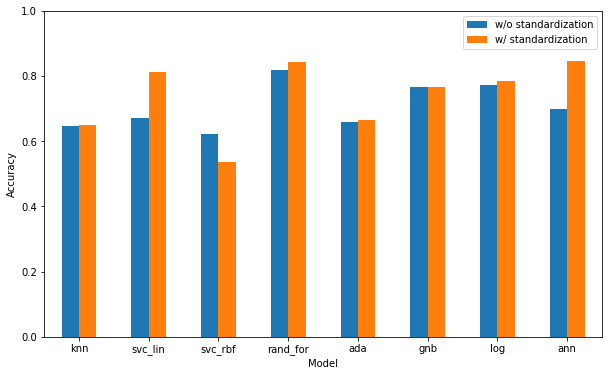

In [3]:
%matplotlib inline
ax = df.drop(['acc_standard_holdout', 'acc_standard_validation'], axis=1).plot(kind='bar', figsize=(10,6), rot=0)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_ybound((0,1))
l = ax.legend(labels=['w/o standardization', 'w/ standardization'])
fig = ax.get_figure()
fig.savefig('images/standardization_acc')

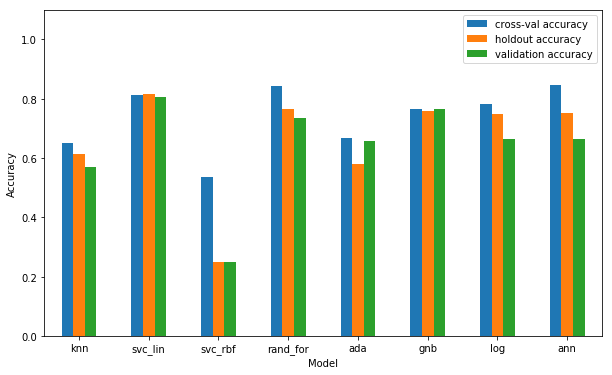

In [4]:
%matplotlib inline
ax = df.drop(['acc'], axis=1).plot(kind='bar', figsize=(10,6), rot=0)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_ybound((0,1.1))
l = ax.legend(labels=['cross-val accuracy','holdout accuracy', 'validation accuracy'])
fig = ax.get_figure()
fig.savefig('images/standardization_validation')